In [1]:
%matplotlib inline

In [36]:
seed = 0
path = 'student-por.csv'
path_nn = 'output/nn.csv'

In [17]:
dataset = {
    'student': {
        'path': path,
        'delimiter': ';',
        'columns_to_exclude': ['G1', 'G2'],
        'column_to_target': 'G3',
        'binarize_target_threshold': 10,
        'test_size': 1 / 3
    }
}

In [18]:
from time import time
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score,\
    precision_recall_curve, average_precision_score, f1_score,\
    precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, learning_curve,\
    StratifiedKFold, RandomizedSearchCV
    
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


def _replace_missing_numeric(df, missing_indicator):
    if missing_indicator:
        df_ = df.copy()
        for c in df.columns:
            try:
                if df_[df_[c].str.contains(missing_indicator,
                                           regex=False)].shape[0] > 0:
                    try:
                        col_float = df[c].replace(missing_indicator,
                                                  np.nan).astype(np.float)
                        col_min = col_float.min()
                        df_[c] = col_float.fillna(col_min - 1)
                    except ValueError:
                        pass
            except AttributeError:
                pass
        return df_
    else:
        return df


def df_prep(dataset_key):
    # config
    dataset_config = dataset[dataset_key]
    path = dataset_config['path']
    delimiter = dataset_config.get('delimiter', ',')
    column_to_target = dataset_config['column_to_target']
    binarize_target_threshold = dataset_config.get('binarize_target_threshold')
    test_size = dataset_config['test_size']
    col_to_exclude = dataset_config['columns_to_exclude']
    missing_indicator = dataset_config.get('missing_indicator')
    positive_class = dataset_config.get('positive_class')

    df = pd.read_csv(path, delimiter=delimiter)
    df_ = df[df.columns.difference(col_to_exclude)]
    df_ = _replace_missing_numeric(df_, missing_indicator)
    cat = [col for col, type_ in df_.dtypes.iteritems()
           if type_ == object and col != column_to_target]
    df_ = pd.get_dummies(df_, dummy_na=True, columns=cat)
    df_ = df_.fillna(-1)
    if binarize_target_threshold:
        df_[column_to_target] = \
            df_[column_to_target] > binarize_target_threshold
    if positive_class:
        df_[column_to_target] = df_[column_to_target] == positive_class

    x = df_[df_.columns.difference([column_to_target])]
    y = df_[column_to_target]
    return df, df_, train_test_split(x, y,
                                     test_size=test_size, random_state=seed)

In [19]:
df, df_, (train_x, test_x, train_y, test_y) = df_prep('student')

In [20]:
train_x.shape

(432, 73)

In [21]:
test_x.shape

(217, 73)

In [22]:
train = train_x.copy()
train['target'] = train_y.astype(pd.np.int)
test = test_x.copy()
test['target'] = test_y.astype(pd.np.int)

In [23]:
train.head(3)

,Dalc,Fedu,Fjob_at_home,Fjob_health,Fjob_nan,Fjob_other,Fjob_services,Fjob_teacher,Medu,Mjob_at_home,...,school_nan,schoolsup_nan,schoolsup_no,schoolsup_yes,sex_F,sex_M,sex_nan,studytime,traveltime,target
458,1,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,4,4,1
108,3,4,0,0,0,1,0,0,4,0,...,0,0,1,0,0,1,0,4,4,1
213,1,4,0,0,0,0,0,1,4,0,...,0,0,1,0,1,0,0,2,1,1


In [24]:
test.head(3)

,Dalc,Fedu,Fjob_at_home,Fjob_health,Fjob_nan,Fjob_other,Fjob_services,Fjob_teacher,Medu,Mjob_at_home,...,school_nan,schoolsup_nan,schoolsup_no,schoolsup_yes,sex_F,sex_M,sex_nan,studytime,traveltime,target
532,1,1,0,0,0,0,1,0,2,0,...,0,0,1,0,0,1,0,2,2,0
375,2,2,1,0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,3,2,1
306,3,4,0,0,0,1,0,0,3,0,...,0,0,1,0,0,1,0,2,2,1


In [27]:
combined = pd.concat([train, test])
s = MinMaxScaler()
c = s.fit_transform(combined)
c = pd.DataFrame(c, columns=combined.columns)
base = 'src/opt/test/'
c.to_csv('{}student.csv'.format(base), index=False, header=None)
x = c[c.columns.difference(['target'])]
y = c.target

In [ ]:
%%time
l = []

for units in [10, 50, 100]:
    for max_iter in range(1, 200 + 1):
        mlp = MLPClassifier(hidden_layer_sizes=(units,), max_iter=max_iter)
        tic = time()
        mlp.fit(x, y)
        elapsed = time() - tic
        l.append({'units': units,
                  'iter': max_iter,
                  'time': elapsed,
                  'acc': mlp.score(x, y)})
        
scores = pd.DataFrame(l)

In [29]:
len(scores)

600

In [30]:
scores.units.value_counts()

100    200
50     200
10     200
Name: units, dtype: int64

In [31]:
scores.head(3)

,acc,iter,time,units
0,0.617874,1,0.010086,10
1,0.563945,2,0.005419,10
2,0.696456,3,0.006481,10


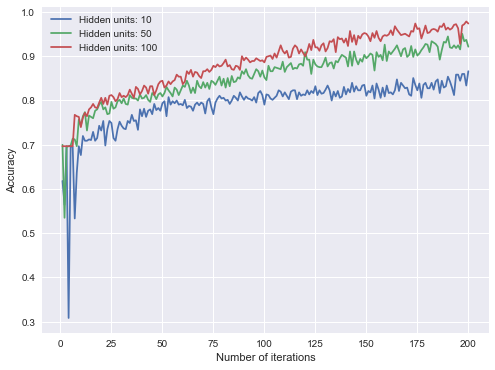

In [32]:
fig, ax = plt.subplots(figsize=(8,6))
for units, g in scores.groupby('units'):
    g.plot(x='iter', y='acc', ax=ax, label='Hidden units: {}'.format(units))
plt.legend()
plt.xlabel('Number of iterations')
_ = plt.ylabel('Accuracy')

In [34]:
combined.target.value_counts(normalize=True)

1    0.696456
0    0.303544
Name: target, dtype: float64

In [35]:
scores.to_csv('scores.csv', index=False)

In [43]:
scores[scores.iter == 200]

,acc,iter,time,units
199,0.865948,200,0.348936,10
399,0.921418,200,0.537313,50
599,0.973806,200,0.765010,100


### Randomized Optimization

In [37]:
df = pd.read_csv(path_nn)

In [38]:
df.head()

,units,iter,algo,acc,time
0,100,1,RHC,0.667180,0.017611
1,100,2,RHC,0.667180,0.033328
2,100,3,RHC,0.667180,0.020014
3,100,4,RHC,0.667180,0.019015
4,100,5,RHC,0.668721,0.022016


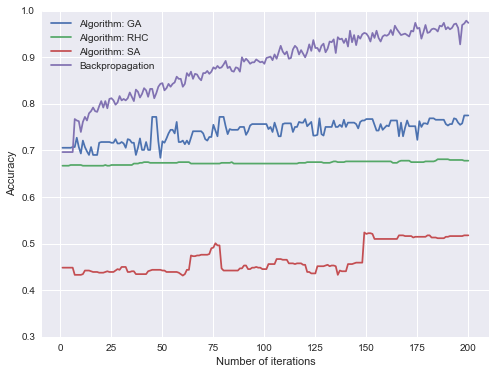

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
for algo, g in df.groupby('algo'):
    g.plot(x='iter', y='acc', ax=ax, label='Algorithm: {}'.format(algo))
scores[scores.units == 100].plot(x='iter', y='acc', ax=ax, label='Backpropagation')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylim([0.3, 1])
_ = plt.ylabel('Accuracy')

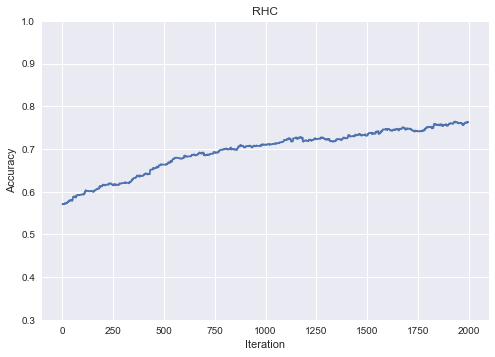

In [70]:
df = pd.DataFrame({'x2': x2, 'x3': x3})
df.mean(axis=1).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('RHC')

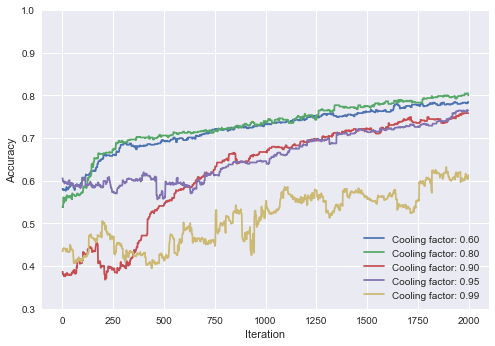

In [115]:
xs = {}
for i in [60, 80, 90, 95, 99]:
    xs['Cooling factor: 0.{}'.format(i)] = pd.read_csv('sa_t{}e12.csv'.format(i),
                        usecols=[3], header=None).loc[:, 3]
    
pd.DataFrame(xs).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc=4)

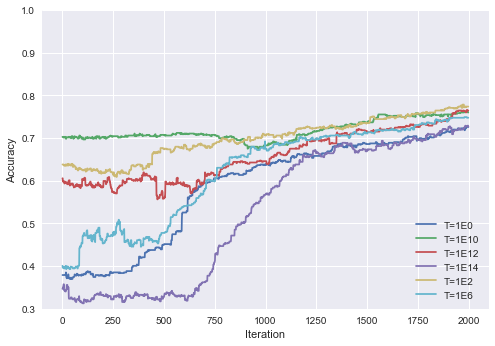

In [112]:
xs = {}
for i in [0, 2, 6, 10, 12, 14]:
    xs['T=1E{}'.format(i)] = pd.read_csv('sa_t95e{}.csv'.format(i),
                        usecols=[3], header=None).loc[:, 3]
    
pd.DataFrame(xs).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc=4)

In [131]:
!ls -lht ga_pop*

-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 01:01 ga_pop100_tomate_100_tomutate80.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:57 ga_pop100_tomate_100_tomutate50.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:53 ga_pop100_tomate_10_tomutate10.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:51 ga_pop100_tomate_50_tomutate10.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:49 ga_pop1000_tomate_100_tomutate10.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:42 ga_pop500_tomate_100_tomutate10.csv
-rw-r--r--@ 1 amir.ziai  10000   4.0K Mar 10 00:38 ga_pop100_tomate_100_tomutate10.csv


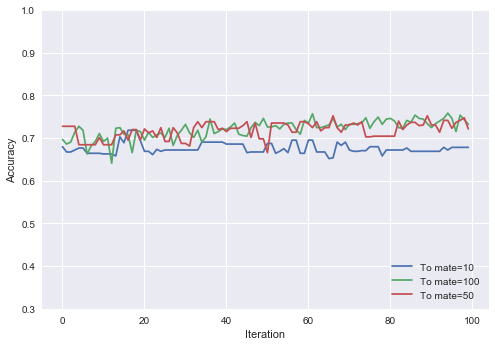

In [127]:
xs = {}
for i in [10, 50, 100]:
    xs['To mate={}'.format(i)] = pd.read_csv('ga_pop100_tomate_{}_tomutate10.csv'.format(i),
                        usecols=[3], header=None).loc[:, 3]
    
pd.DataFrame(xs).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc=4)

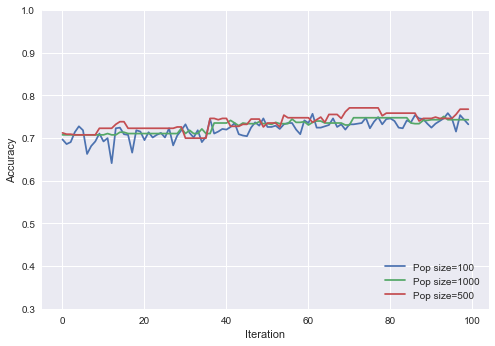

In [130]:
xs = {}
for i in [100, 500, 1000]:
    xs['Pop size={}'.format(i)] = pd.read_csv('ga_pop{}_tomate_100_tomutate10.csv'.format(i),
                        usecols=[3], header=None).loc[:, 3]
    
pd.DataFrame(xs).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc=4)

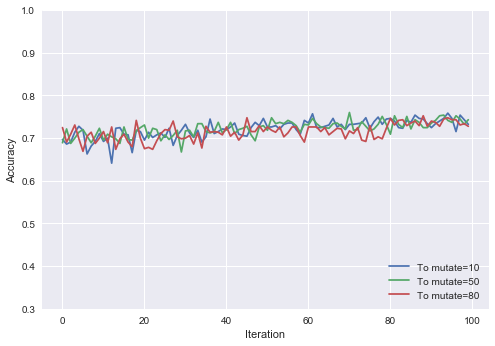

In [133]:
xs = {}
for i in [10, 50, 80]:
    xs['To mutate={}'.format(i)] = pd.read_csv('ga_pop100_tomate_100_tomutate{}.csv'.format(i),
                        usecols=[3], header=None).loc[:, 3]
    
pd.DataFrame(xs).plot()
plt.ylim([0.3, 1])
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend(loc=4)